# Processing USD Twitter sentiment

In this notebook, I am going to load the tweets about the Federal Reserve in order to estimate sentiment around the US dollar in each day. This will be used as a proxy of the expectations of the economic agents about this fiat currency (see the README for further details) which is a direct competitor to the EUR. A higher positive sentiment in this currency should associate with lower EUR value.

This notebook will process Twitter data using the functions created in `02b_data_preparation_twitter_sentiment_eur.ipynb`. See that notebook for further details about the calculations done here.

Set the working directory as usual:

In [1]:
import os

os.chdir("/media/dftortosa/Windows/Users/dftor/Documents/diego_docs/industry/data_incubator/capstone_project/")
os.getcwd()

'/media/dftortosa/Windows/Users/dftor/Documents/diego_docs/industry/data_incubator/capstone_project'

Import VADER and prepare the functions to clean the tweets, perform the sentiment analysis and calculate metrics with all tweets per day:

In [2]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [3]:
import re
def clean_tweet(tweet):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t]) |(\w+:\/\/\S+)", " ", tweet).split()).replace("#", "")

In [4]:
def sentiment_per_row(raw_tweet, sentiment_type="compound"):
        
    #clean
    tweet_cleaned = clean_tweet(raw_tweet)
    
    #get the negative sentiment
    sentiment = analyzer.polarity_scores(tweet_cleaned)[sentiment_type]

    #return
    return sentiment

In [5]:
def groupby_calcs(operation, metric_name, args="", n_previous_days=1, currency=""):
        
    #get the string with the operation name
    string_evaluate = 'sentiment_results_df_' + currency + '.groupby("date")["sentiment"].' + operation + '(' + args + ').to_frame()'
        #do operations for the sentiment of each day and then convert to df

    #evaluate to get the DF with the calculations per day
    data_frame = eval(string_evaluate)
    
    #extract the range of days for which we have data
    time_range = pd.date_range(np.min(np.unique(data_frame.index)), 
                        np.max(np.unique(data_frame.index)))
    
    #fill with NaN those dates with data
    data_frame = data_frame.reindex(time_range, fill_value=np.NaN)
        #https://stackoverflow.com/questions/15610805/accessing-row-from-previous-day-in-pandas-dataframe-with-apply
    
    #get sentiment of the previous days
    data_frame['sentiment'] = data_frame['sentiment'].shift(n_previous_days)
        #https://stackoverflow.com/questions/19324453/add-missing-dates-to-pandas-dataframe
        
    #reset the index
    data_frame = data_frame.reset_index(level=0)
        #set the index (date) as column 
  
    #change the column name for sentiment
    data_frame = data_frame.rename(columns={'index': 'date', 'sentiment': metric_name + '_sent_' + currency + '_previous_' + str(n_previous_days) + '_days'})

    #append the df to the list
    return data_frame
    
def groupby_calcs_across_dates(list_metrics, previous_date, currency=""):
        
    #open list to save each calculation
    list_data_frames = []
    
    #apply each operation
    for metric in list_metrics:
        
        #for std
        if metric == "std":
            #use ddof=0 to get zero for cases with 1 tweet per day (see above)
            result_calc = groupby_calcs(operation=metric, 
                          metric_name=metric, 
                          args='ddof=0', 
                          n_previous_days=previous_date, 
                          currency=currency)
        elif "quantile" in metric: #if quantile
            #get the operation name and the quantile number
            operation_name = metric.split("_")[0]
            quantile_number = metric.split("_")[1]
            result_calc = groupby_calcs(operation=operation_name, 
                          metric_name=metric, 
                          args=quantile_number, 
                          n_previous_days=previous_date, 
                          currency=currency) 
        elif "range" in metric:
            result_calc = groupby_calcs(operation="apply", 
                          metric_name=metric, 
                          args="lambda x: np.max(x) - np.min(x)",
                          n_previous_days=previous_date, 
                          currency=currency)
        elif "iqr" in metric:
            result_calc = groupby_calcs(operation="apply", 
                          metric_name=metric, 
                          args="lambda x: (np.percentile(x, 75) - np.percentile(x, 25))",
                          n_previous_days=previous_date, 
                          currency=currency)   
        else: 
            result_calc = groupby_calcs(operation=metric, 
                          metric_name=metric, 
                          n_previous_days=previous_date, 
                          currency=currency)
        
        #save in the list
        list_data_frames.append(result_calc)
    return list_data_frames

Run all the functions to obtain the final data frame with the metrics of the sentiment per day around the USD:

In [6]:
import pandas as pd
import numpy as np

#load the tweets about the Federal Reserve (Fed)
tweets_df_usd = pd.read_json("data/json_files/hashtag_fed_twitter_1999_1_1.json", lines=True)

#reset the indeces to avoid problems when indexing
tweets_df_usd = tweets_df_usd.reset_index(drop=True)
    #use drop drop parameter to avoid the old index being added as a column

#check for duplicated IDs
print(f'There are duplicated tweets? {tweets_df_usd["id"].duplicated().any()}')
    
#remove tweets with a duplicated id
tweets_df_usd = tweets_df_usd.drop_duplicates(subset=['id'])

#select only tweets in english
tweets_df_usd_en = tweets_df_usd[tweets_df_usd["lang"] == "en"]
print(f"Shape after selecting English tweets {tweets_df_usd_en.shape}")
    
#clean 
del(tweets_df_usd)

#calculate sentiment across the data.frame
import multiprocessing as mp
with mp.Pool(10) as pool:
    tweets_df_usd_en["sentiment"] = pool.map(sentiment_per_row, tweets_df_usd_en["rawContent"])
        #for each row in tweets_df_usd_en["rawContent"], apply sentiment_per_row across 10 cores
        #https://stackoverflow.com/questions/45545110/make-pandas-dataframe-apply-use-all-cores
    pool.close()
    
#change the sign to follow the same sense than in EUR sentiment (higher values more positive for EUR)
tweets_df_usd_en["sentiment"] = -tweets_df_usd_en["sentiment"]
      #USD is the competitor of EUR, so they should be opposite

#get the date and sentiment
sentiment_results_df_usd = tweets_df_usd_en[["date", "sentiment"]]
sentiment_results_df_usd

#clean
del(tweets_df_usd_en)

#leave only year, month and day
sentiment_results_df_usd["date"] = pd.to_datetime(sentiment_results_df_usd["date"].dt.strftime('%Y-%m-%d'))
    #https://stackoverflow.com/questions/38067704/how-to-change-the-datetime-format-in-pandas
    #https://stackoverflow.com/questions/20689288/converting-pandas-columns-to-datetime64-including-missing-values

#check we have rows ordered in chronologicla order
print(f"tweets in chronological order? {sentiment_results_df_usd.equals(sentiment_results_df_usd.sort_index())}")

#define a list of operations to do
list_metrics = ["quantile_0.05",
                "quantile_0.1",
                "quantile_0.2",
                "quantile_0.3",
                "quantile_0.4",
                "quantile_0.5",
                "quantile_0.6",
                "quantile_0.7",
                "quantile_0.8",
                "quantile_0.9",
                "quantile_0.95",
                "mean",
                "min",
                "max",
                "sum",
                "count", 
                "range", 
                "var", 
                "std", 
                "iqr"]

#get sentiment previous days
list_dates = np.arange(1, 16, 1)

#open a pool with 10 processes
pool_dates = mp.Pool(processes=10)

#apply the function for each previous day in parallel across 10 cores
list_data_frames_usd = [pool_dates.apply_async(groupby_calcs_across_dates, args=(list_metrics, previous_date, "usd")).get() for previous_date in list_dates]
    #https://stackoverflow.com/questions/42843203/how-to-get-the-result-of-multiprocessing-pool-apply-async

#close the pool
pool_dates.close()

#flatten list
flat_list_usd = [item for sublist in list_data_frames_usd for item in sublist]
flat_list_usd

#check
print(f"correct number of data frames? {len(flat_list_usd) == len(list_metrics) * len(list_dates)}")

#merge all data.frames
from functools import reduce

#merge them using reduce
df_merged = reduce(lambda left, right: pd.merge(left, right, on=['date'], how='inner'), [element for element in flat_list_usd])
    #leave only those rows having date in the datasets of currency value and sentiment
    #https://stackoverflow.com/questions/44327999/python-pandas-merge-multiple-dataframes
df_merged
    #note that here the previous eur pricing can be different than the eur pricing of the previous row
    #because when merging we lose days without tweet sentiment, so there is no longer continuous days

There are duplicated tweets? False
Shape after selecting English tweets (1116912, 28)
tweets in chronological order? True
correct number of data frames? True


,date,quantile_0.05_sent_usd_previous_1_days,quantile_0.1_sent_usd_previous_1_days,quantile_0.2_sent_usd_previous_1_days,quantile_0.3_sent_usd_previous_1_days,quantile_0.4_sent_usd_previous_1_days,quantile_0.5_sent_usd_previous_1_days,quantile_0.6_sent_usd_previous_1_days,quantile_0.7_sent_usd_previous_1_days,quantile_0.8_sent_usd_previous_1_days,...,quantile_0.95_sent_usd_previous_15_days,mean_sent_usd_previous_15_days,min_sent_usd_previous_15_days,max_sent_usd_previous_15_days,sum_sent_usd_previous_15_days,count_sent_usd_previous_15_days,range_sent_usd_previous_15_days,var_sent_usd_previous_15_days,std_sent_usd_previous_15_days,iqr_sent_usd_previous_15_days
0,2008-03-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2008-03-19,0.27320,0.27320,0.27320,0.27320,0.2732,0.2732,0.27320,0.27320,0.27320,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2008-03-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2008-03-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2008-03-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5268,2022-08-20,-0.73673,-0.57896,-0.38180,-0.16130,0.0000,-0.0000,0.00000,0.25000,0.44040,...,0.700300,-0.050351,-0.9418,0.9633,-31.3181,622.0,1.9051,0.203222,0.450439,0.653100
5269,2022-08-21,-0.80242,-0.62970,-0.41006,-0.20744,0.0000,-0.0000,0.00000,0.28384,0.47312,...,0.783040,0.029639,-0.9686,0.8885,5.6017,189.0,1.8571,0.184094,0.427926,0.644800
5270,2022-08-22,-0.65988,-0.55641,-0.42432,-0.31302,-0.1280,0.0000,0.00000,0.00000,0.31672,...,0.726750,-0.034770,-0.9309,0.9267,-5.9457,171.0,1.8576,0.192045,0.436946,0.626700
5271,2022-08-23,-0.75598,-0.63690,-0.45880,-0.25000,0.0000,-0.0000,0.00000,0.22630,0.42042,...,0.700300,-0.062026,-0.9134,0.9690,-28.6558,462.0,1.8824,0.197261,0.443659,0.681550


See and remove NAs:

In [7]:
#see NaN
print(df_merged.isnull().sum())
    #We have NaNs for days that do not have prior twitter data in the selected previous day

#remove NA cases
df_merged = df_merged.dropna()
df_merged

date                                        0
quantile_0.05_sent_usd_previous_1_days    345
quantile_0.1_sent_usd_previous_1_days     345
quantile_0.2_sent_usd_previous_1_days     345
quantile_0.3_sent_usd_previous_1_days     345
                                         ... 
count_sent_usd_previous_15_days           359
range_sent_usd_previous_15_days           359
var_sent_usd_previous_15_days             393
std_sent_usd_previous_15_days             359
iqr_sent_usd_previous_15_days             359
Length: 301, dtype: int64


,date,quantile_0.05_sent_usd_previous_1_days,quantile_0.1_sent_usd_previous_1_days,quantile_0.2_sent_usd_previous_1_days,quantile_0.3_sent_usd_previous_1_days,quantile_0.4_sent_usd_previous_1_days,quantile_0.5_sent_usd_previous_1_days,quantile_0.6_sent_usd_previous_1_days,quantile_0.7_sent_usd_previous_1_days,quantile_0.8_sent_usd_previous_1_days,...,quantile_0.95_sent_usd_previous_15_days,mean_sent_usd_previous_15_days,min_sent_usd_previous_15_days,max_sent_usd_previous_15_days,sum_sent_usd_previous_15_days,count_sent_usd_previous_15_days,range_sent_usd_previous_15_days,var_sent_usd_previous_15_days,std_sent_usd_previous_15_days,iqr_sent_usd_previous_15_days
447,2009-06-08,-0.391100,-0.32770,-0.25418,-0.22518,-0.17880,-0.00,0.00000,0.20400,0.35148,...,0.245880,0.091067,-0.0000,0.2732,0.2732,3.0,0.2732,0.024879,0.128788,0.136600
448,2009-06-09,-0.526700,-0.52670,-0.44330,-0.28638,-0.06364,0.00,0.00000,0.00000,0.00000,...,0.480525,0.185367,-0.0000,0.4939,1.1122,6.0,0.4939,0.052675,0.209513,0.374775
449,2009-06-10,-0.326940,-0.10898,0.00000,0.00000,0.00000,-0.00,0.00000,0.00000,0.00000,...,0.223290,-0.051267,-0.4019,0.2481,-0.1538,3.0,0.6500,0.107596,0.267826,0.325000
450,2009-06-11,-0.725885,-0.59397,-0.33512,0.00000,0.00000,0.35,0.41328,0.54754,0.60154,...,0.447560,-0.101237,-0.8622,0.7814,-4.9606,49.0,1.6436,0.140303,0.370729,0.509800
451,2009-06-12,-0.376910,-0.24554,-0.14400,0.00000,0.00000,0.00,0.00000,0.00000,0.00000,...,0.701780,0.361800,-0.0516,0.7351,1.0854,3.0,0.7867,0.155930,0.322418,0.393350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5268,2022-08-20,-0.736730,-0.57896,-0.38180,-0.16130,0.00000,-0.00,0.00000,0.25000,0.44040,...,0.700300,-0.050351,-0.9418,0.9633,-31.3181,622.0,1.9051,0.203222,0.450439,0.653100
5269,2022-08-21,-0.802420,-0.62970,-0.41006,-0.20744,0.00000,-0.00,0.00000,0.28384,0.47312,...,0.783040,0.029639,-0.9686,0.8885,5.6017,189.0,1.8571,0.184094,0.427926,0.644800
5270,2022-08-22,-0.659880,-0.55641,-0.42432,-0.31302,-0.12800,0.00,0.00000,0.00000,0.31672,...,0.726750,-0.034770,-0.9309,0.9267,-5.9457,171.0,1.8576,0.192045,0.436946,0.626700
5271,2022-08-23,-0.755980,-0.63690,-0.45880,-0.25000,0.00000,-0.00,0.00000,0.22630,0.42042,...,0.700300,-0.062026,-0.9134,0.9690,-28.6558,462.0,1.8824,0.197261,0.443659,0.681550


Plot metrics for just the previous day:

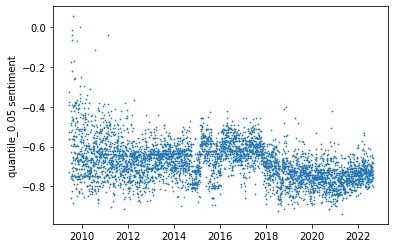

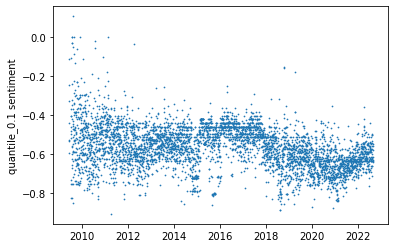

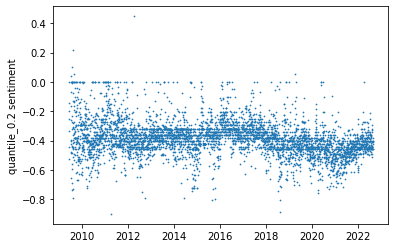

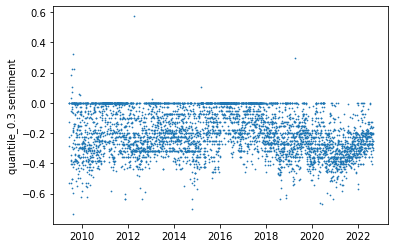

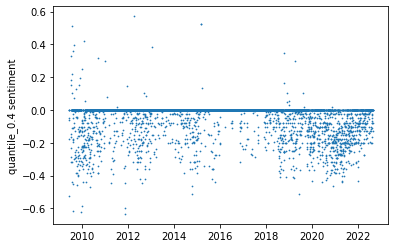

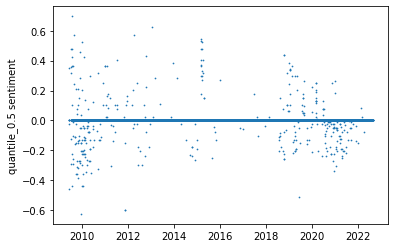

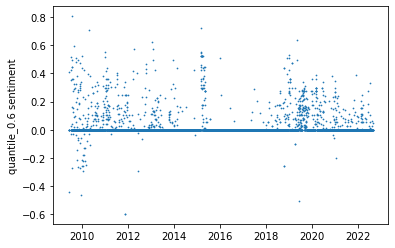

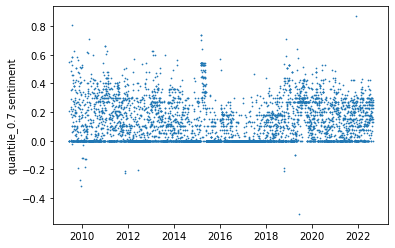

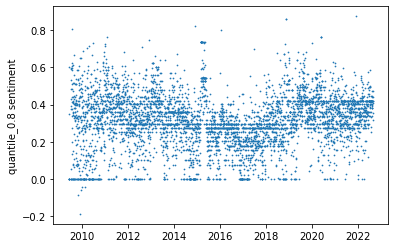

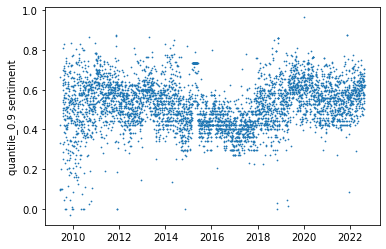

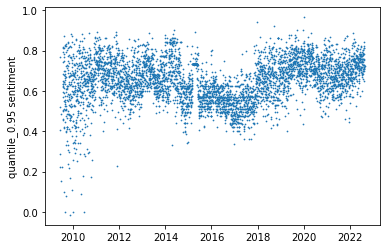

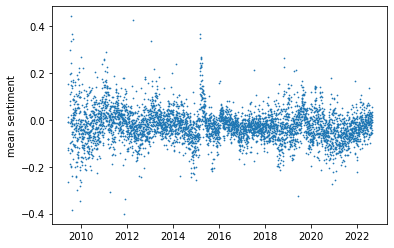

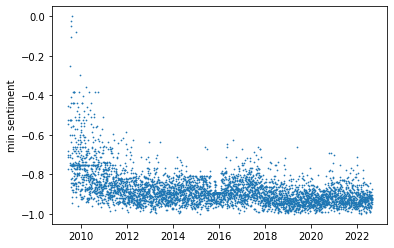

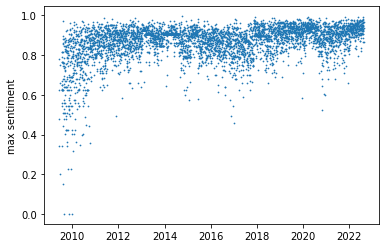

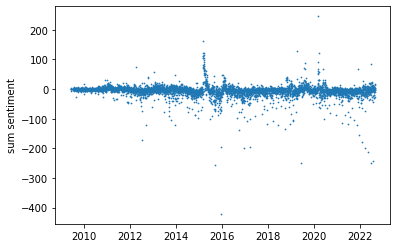

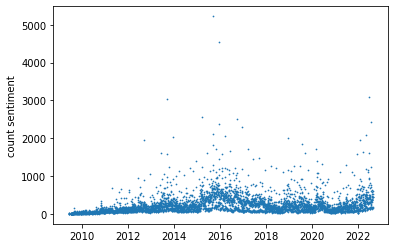

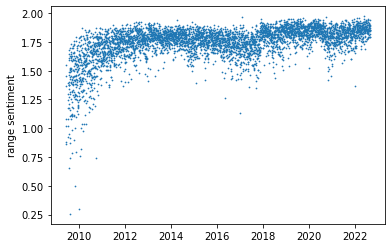

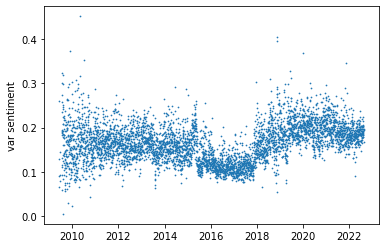

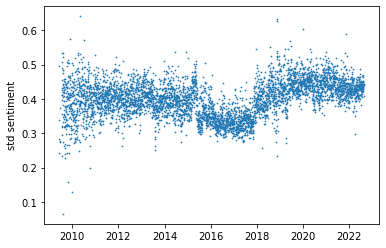

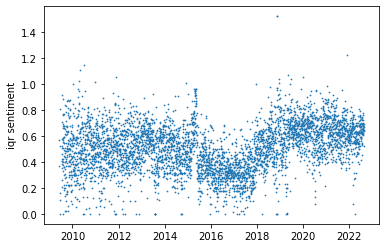

In [8]:
import matplotlib.pyplot as plt

#for each metric
for metric in list_metrics:
    
    #plot scatter against date and eur pricing
    plt.scatter(df_merged["date"], df_merged[metric + "_sent_usd_previous_1_days"], s=0.5)

    #set ylabel
    plt.ylabel(metric + " sentiment")

    #close
    plt.show()

Save the final data frame:

In [9]:
#save the final data.frame with all metrics and eur pricing
df_merged.to_csv("results/twitter_sentiment_data_usd.csv.gz", compression="gzip", index=False)
#df_merged = pd.read_csv("results/twitter_sentiment_data.csv.gz", compression="gzip")